# ATMS 523 Final Project
### Author: Domenic Brooks

# Objective
The purpose of this project is to investigate the relationship between teleconnection patterns and winter snowfall totals for a given city. The goal of this project is to produce a tool to run an ML model to predict the amount of snowfall based on the given teleconnections. 

# Data
For snowfall, the dataset used is ERA-5 reanalysis. While perhaps not the most accurate or precise for snowfall records, it does provide a continous gridded dataset for a period of record dating back to 1940, which is essential for gathering enough seasons for the ML model training. 

For teleconnections, the NOAA Climate Prediction Center (CPC) and NCEI provide tabular datasets for monthly indices dating back to 1950 for various teleconnections, the ones which will be used in this project are:

- El Nino Southern Oscillation (ENSO)
- North Atlantic Oscillation (NAO)
- Arctic Osciallation (AO)
- Pacific North American Oscillation (PNA)
- Pacific Decadal Oscillation (PDO)
- Indian Ocean Dipole (IOD)

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import dask
import scipy.stats as stats
import cartopy.feature as cfeature
import cartopy.crs as ccrs 

# Teleconnection Dataset Processing

In [3]:
# ENSO
enso = pd.read_csv('https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.el_nino.dat',
                   sep=r'\s+', header=None, skiprows=0, engine='python')
# Grab ENSO 3.4 values and reformat for proper merging later                   
enso = enso[[0,1,4]].pivot_table(values=4, index=0, columns=1).reset_index()

# NAO
nao = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii.table',
                  sep=r'\s+', header=None, skiprows=1, engine='python')

# AO
ao = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii.table',
                  sep=r'\s+', header=None, skiprows=1, engine='python')

# PNA
pna = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.pna.monthly.b5001.current.ascii.table',
                  sep=r'\s+', header=None, skiprows=1, engine='python')  

# PDO
pdo = pd.read_csv('https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.pdo.dat',
                  sep=r'\s+', header=None, skiprows=2, engine='python')

# IOD
iod = pd.read_csv('https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.iod.dat',
                  sep=r'\s+', header=None, skiprows=1, engine='python')
# Grab difference values and reformat for proper merging later              
iod = iod[[0,1,4]].pivot_table(values=4, index=0, columns=1).reset_index()

In [4]:
###### Create merged dataframe for all indices #######

enso_new=pd.DataFrame()
nao_new=pd.DataFrame()
pdo_new=pd.DataFrame()
ao_new=pd.DataFrame()
pna_new=pd.DataFrame()
iod_new=pd.DataFrame()

# Create monthly date intervals
enso_new['Date'] = pd.date_range(start=datetime.datetime(enso[0].iloc[0],1,1),end=datetime.datetime(enso[0].iloc[-1],12,1),freq="MS")
nao_new['Date'] = pd.date_range(start=datetime.datetime(nao[0].iloc[0],1,1),end=datetime.datetime(nao[0].iloc[-1],12,1),freq="MS")
pdo_new['Date'] = pd.date_range(start=datetime.datetime(pdo[0].iloc[0],1,1),end=datetime.datetime(pdo[0].iloc[-1],12,1),freq="MS")
ao_new['Date'] = pd.date_range(start=datetime.datetime(ao[0].iloc[0],1,1),end=datetime.datetime(ao[0].iloc[-1],12,1),freq="MS")
pna_new['Date'] = pd.date_range(start=datetime.datetime(pna[0].iloc[0],1,1),end=datetime.datetime(pna[0].iloc[-1],12,1),freq="MS")
iod_new['Date'] = pd.date_range(start=datetime.datetime(iod[0].iloc[0],1,1),end=datetime.datetime(iod[0].iloc[-1],12,1),freq="MS")

# Set the monthly timesteps to the index
enso_new = enso_new.set_index('Date')
nao_new = nao_new.set_index('Date')
pdo_new = pdo_new.set_index('Date')
ao_new = ao_new.set_index('Date')
pna_new = pna_new.set_index('Date')
iod_new = iod_new.set_index('Date')

# Add teleconnection indices to date index
enso_new['ENSO']=enso.loc[:,1:].stack(dropna=False).values
nao_new['NAO']=nao.loc[:,1:].stack(dropna=False).values
pdo_new['PDO']=pdo.loc[:,1:].stack(dropna=False).values
ao_new['AO']=ao.loc[:,1:].stack(dropna=False).values
pna_new['PNA']=pna.loc[:,1:].stack(dropna=False).values
iod_new['IOD']=iod.loc[:,1:].stack(dropna=False).values

# Merge all dataframes and also account for missnig value markers
newdf_all = pd.merge(enso_new,pdo_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['PDO'] >= 99.,'PDO'] = np.nan
newdf_all.loc[newdf_all['ENSO'] <= -99.9,'ENSO'] = np.nan
newdf_all = pd.merge(newdf_all,nao_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['NAO'] <= -99.9,'NAO'] = np.nan
newdf_all = pd.merge(newdf_all,ao_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['AO'] <= -99.9,'AO'] = np.nan
newdf_all = pd.merge(newdf_all,pna_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['PNA'] <= -99.9,'PNA'] = np.nan
newdf_all = pd.merge(newdf_all,iod_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['IOD'] <= -99.9,'IOD'] = np.nan

# Resample to seasonal means
#newdf_all = newdf_all.resample('QS-DEC', closed='left', label='left').mean()

newdf_all

/tmp/ipykernel_1177658/2434704326.py:27: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  enso_new['ENSO']=enso.loc[:,1:].stack(dropna=False).values
/tmp/ipykernel_1177658/2434704326.py:28: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  nao_new['NAO']=nao.loc[:,1:].stack(dropna=False).values
/tmp/ipykernel_1177658/2434704326.py:29: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this

,ENSO,PDO,NAO,AO,PNA,IOD
Date,,,,,,
1950-01-01,-2.04,-1.61,0.92,-0.060,-2.34,-0.01
1950-02-01,-1.72,-2.17,0.40,0.627,-1.04,-0.51
1950-03-01,-1.38,-1.89,-0.36,-0.008,0.24,-0.29
1950-04-01,-1.41,-1.99,0.73,0.555,0.01,-0.12
1950-05-01,-1.62,-3.19,-0.59,0.072,-0.55,-0.09
...,...,...,...,...,...,...
2025-08-01,-0.32,-3.19,0.26,0.036,-0.36,-0.45
2025-09-01,-0.50,-2.31,-0.80,0.048,0.81,-0.57
2025-10-01,-0.48,-2.36,-0.96,0.064,1.42,-0.83


# ERA-5 data retrieval

In [4]:
# Start dask client
from dask.distributed import Client
client = Client() 
client

/global/homes/d/dbrooks/.conda/envs/atms-shap/lib/python3.11/site-packages/distributed/node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35053 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:35053/status,
Dashboard: http://127.0.0.1:35053/status,Workers: 16
Total threads: 256,Total memory: 502.97 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43351,Workers: 0
Dashboard: http://127.0.0.1:35053/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46323,Total threads: 16
Dashboard: http://127.0.0.1:45989/status,Memory: 31.44 GiB
Nanny: tcp://127.0.0.1:45055,


In [5]:
# Load full ERA-5 datast
ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks={"time": 30},
    storage_options=dict(token='anon'),
)
ds

<xarray.Dataset> Size: 4PB
Dimensions:                                                          (
                                                                      time: 1323648,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * time                                                             (time) datetime64[ns] 11MB ...
  * latitude                                                         (latitude) float32 3kB ...
  * longitude                                                        (longitude) float32 6kB ...
  * level                                                            (level) int64 296B ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    wave_spectral_skewness                                           (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    zero_degree_level                                                (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
Attributes:
    last_updated:           2025-12-08 02:08:54.302123+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-08-31
    valid_time_stop_era5t:  2025-12-02

In [ ]:
# Function for selecting city data
def get_era5_data_for_city(ds, var, city_lon, city_lat, start_time, end_time):
    """
    This function serves to grab ERA-5 data for a given variable
    for a given city for a given timeframe.

    Inputs:
    - ds (xarray.Dataset): ERA-5 dataset with all the variables.
    - var (str): Variable you want to grab from the data.
    - city_lon (float): Longitude of selected city.
    - city_lat (float): Latitude of selected city.
    - start time (str): Desired start time (yyyy-mm-dd HH:MM)
    - end time (str): Desired end time (yyyy-mm-dd HH:MM)

    Returns:
    - ds2 (xarray.DataArray): A DataArray containing the data for grid point.
    """

    ds2 = ds[var].sel(
        latitude=city_lat,
        longitude=city_lon+360,
        method='nearest'
    )

    ds2 = ds2.sel(time=slice(start_time, end_time))

    return ds2

var = 'snowfall'
city_lon, city_lat = -76.609484,39.289221 # Baltimore, MD
#city_lon, city_lat = -119.707428,37.714845 # Yosemite
start_time, end_time = '1950-09-01 01:00','2025-02-28 23:00'

# Run function
city_ds = get_era5_data_for_city(
    ds, var, city_lon, city_lat, start_time, end_time)

In [7]:
# Loading into memory takes ~4 min
city_ds = city_ds.compute()
city_ds = city_ds * 1000 # m to mm
print(city_ds)

<xarray.DataArray 'snowfall' (time: 653039)> Size: 3MB
array([ 0.000000e+00,  0.000000e+00,  0.000000e+00, ..., -4.656613e-07,
       -4.656613e-07, -4.656613e-07], shape=(653039,), dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 5MB 1950-09-01T01:00:00 ... 2025-02-28T2...
    latitude   float32 4B 37.75
    longitude  float32 4B 240.2
Attributes:
    long_name:      Snowfall
    short_name:     sf
    standard_name:  lwe_thickness_of_snowfall_amount
    units:          m of water equivalent


In [5]:
#city_ds.to_netcdf('Baltimore_snowfall.nc', engine='h5netcdf')
city_ds = xr.open_dataarray('Baltimore_snowfall.nc', engine='h5netcdf')

# Format and merge dataframes

In [6]:
# Turn array into dataframe, and resample to seasonal totals
snow_ds = city_ds.to_dataframe().drop(['latitude','longitude'], axis=1)
#snow_ds = snow_ds.resample('QS-DEC', closed='left', label='left').sum()
snow_ds = snow_ds.resample('MS', closed='left', label='left').sum()
snow_ds.index.name = 'Date'

# Keep only monthly totals from select month
snow_ds = snow_ds[snow_ds.index.month.isin([2])].copy()
snow_ds

,snowfall
Date,
1951-02-01,6.260388
1952-02-01,0.541882
1953-02-01,1.272336
1954-02-01,1.808713
1955-02-01,18.714376
...,...
2021-02-01,50.568836
2022-02-01,4.900810
2023-02-01,4.748949


In [7]:
from scipy import signal
# Detrend the data (due to any long term trends in snowfall)
snow_ds_detrended = signal.detrend(snow_ds['snowfall'].values)
snow_ds['snowfall_detrended'] = snow_ds_detrended
snow_ds['snowfall_detrended']

Date
1951-02-01   -14.278310
1952-02-01   -19.991358
1953-02-01   -19.255444
1954-02-01   -18.713608
1955-02-01    -1.802485
                ...    
2021-02-01    30.412277
2022-02-01   -15.250290
2023-02-01   -15.396692
2024-02-01    -6.090732
2025-02-01    -4.785299
Freq: 12MS, Name: snowfall_detrended, Length: 75, dtype: float32

In [8]:
# Get winter snowfall mean for 1981-2010
mean_djf_snow = snow_ds['snowfall_detrended']['1981-12-01':'2010-12-01'].mean()
mean_djf_snow

# Get Anomaly 
snow_anom = snow_ds['snowfall_detrended'] - mean_djf_snow

# Standardize the anoms
# Compute long term mean and std
mean = snow_anom.mean()
std = snow_anom.std()

# Avoid division by zero
#std = std.where(std != 0)

# Standardize (subtract mean and divide by std)
snow_standard = (snow_anom - mean) / std
snow_standard

Date
1951-02-01   -0.688372
1952-02-01   -0.963804
1953-02-01   -0.928325
1954-02-01   -0.902203
1955-02-01   -0.086900
                ...   
2021-02-01    1.466207
2022-02-01   -0.735232
2023-02-01   -0.742291
2024-02-01   -0.293641
2025-02-01   -0.230705
Freq: 12MS, Name: snowfall_detrended, Length: 75, dtype: float32

In [9]:
# Merge dataframes
df_full = newdf_all.merge(snow_standard, how='outer', on='Date')

# Keep only n month for teleconnections
# and m month for snowfall                  n m
df_full = df_full[df_full.index.month.isin([1,2])].copy()
df_full = df_full.iloc[1:-2]

# Shift winter snowfall anoms up by one row to match with previous month indices
df_full['djf_snow_anom'] = df_full['snowfall_detrended'].shift(-1)
df_full = df_full.drop('snowfall_detrended', axis=1).dropna(axis=0)

df_full

,ENSO,PDO,NAO,AO,PNA,IOD,djf_snow_anom
Date,,,,,,,
1951-01-01,-1.34,-1.19,0.08,-0.085,-0.41,-0.05,-0.688372
1952-01-01,0.08,-2.19,0.93,0.368,-1.98,0.05,-0.963804
1953-01-01,0.14,-0.16,0.33,-1.036,0.65,0.40,-0.928325
1954-01-01,0.38,-1.13,0.37,-0.148,-1.14,-0.29,-0.902203
1955-01-01,-0.98,-0.23,-1.84,-1.163,0.40,-0.42,-0.086900
...,...,...,...,...,...,...,...
2020-01-01,0.55,-1.41,1.34,2.419,-0.24,0.14,-0.957666
2021-01-01,-1.05,-0.61,-1.11,-2.484,0.19,0.12,1.466207
2022-01-01,-0.98,-2.40,1.08,0.848,1.01,-0.26,-0.735232


# Some EDA with Correlation and Pair plots

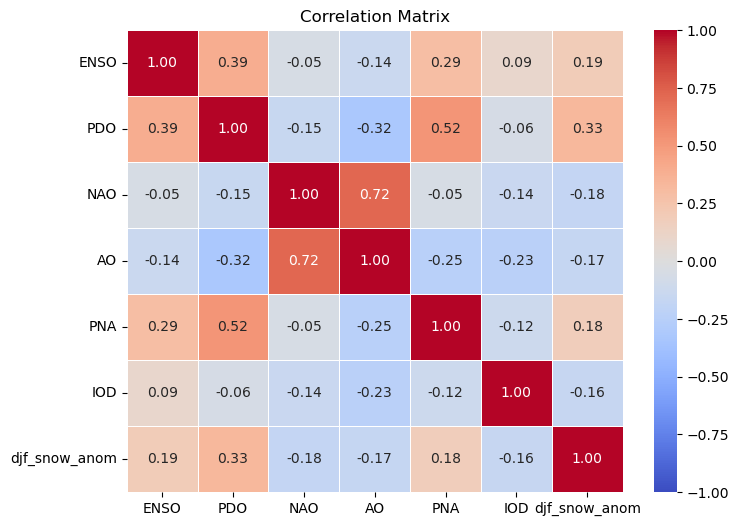

<Figure size 500x500 with 0 Axes>

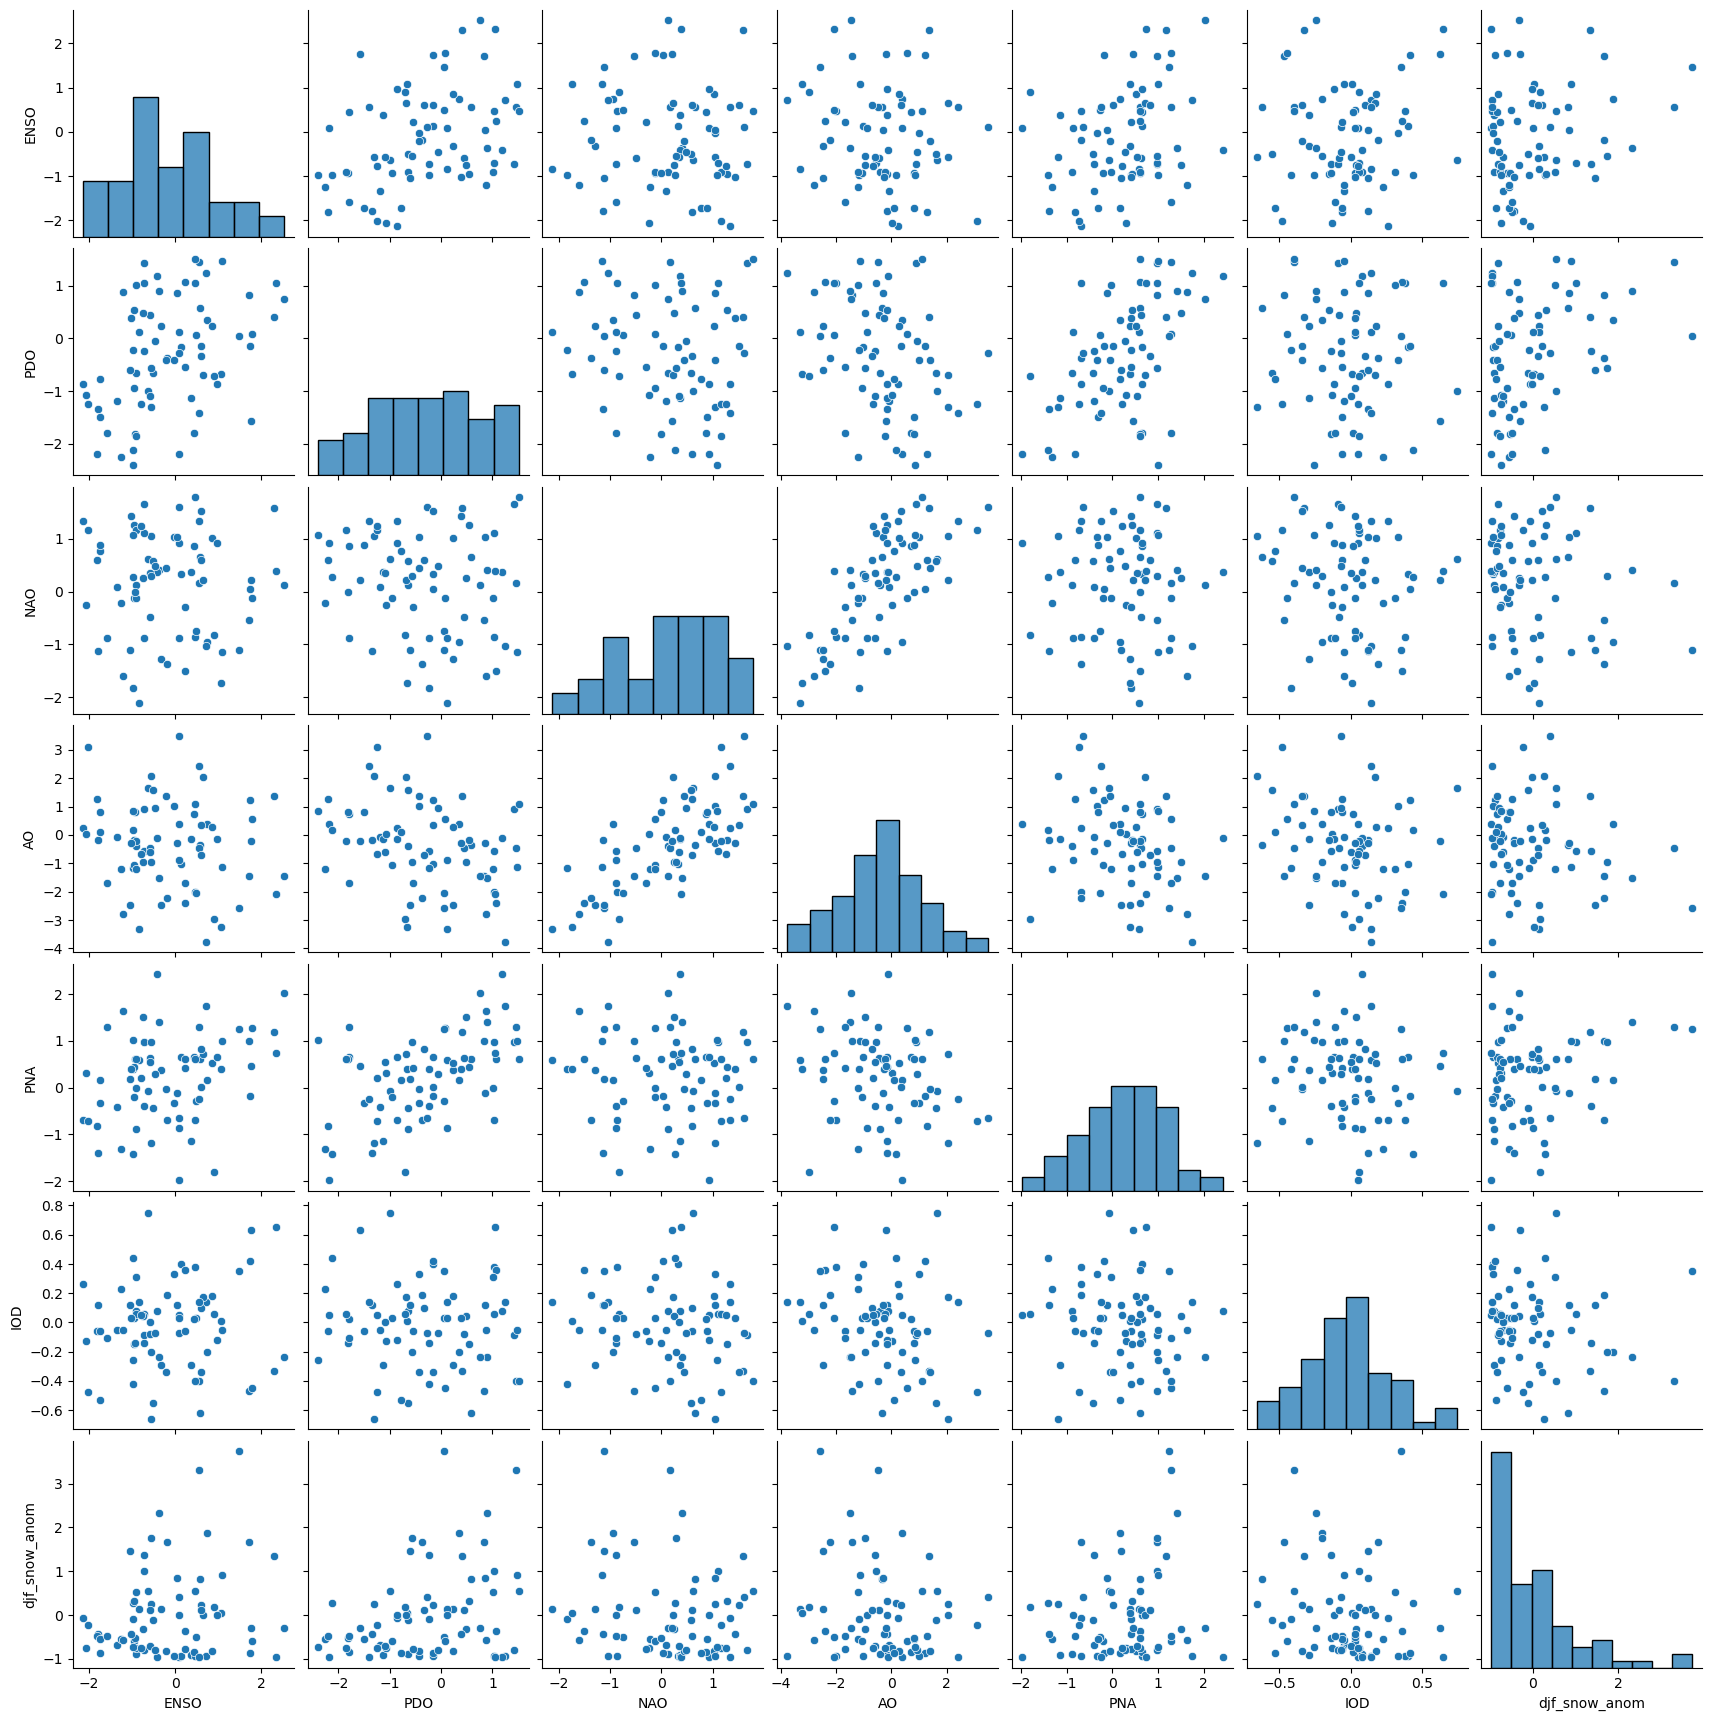

In [10]:
import seaborn as sns

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_full.corr(), cmap='coolwarm', annot=True, 
            fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

# Create pairplot
plt.figure(figsize=(5, 5))
sns.pairplot(df_full)
plt.show()

# Test different models

Trying different non-linear, tree models. Specifically the Random Forest Regression, GB Regression, and XGB Regression.
The metrics will be compared once all are run to determine the best model.

In [11]:

from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from xgboost import XGBRegressor

RANDOM_STATE = 42

# Split data into test and training
# X = features
# y = target
# Since we are working with chronological data,
# we split it up into the first ~55 years for training
# and the last 20 for testing
split_date = "2004-01-01"  # adjust if desired

train = df_full[df_full.index < split_date]
test = df_full[df_full.index >= split_date]

X_train = train[['ENSO','PDO','NAO','AO','PNA','IOD']]
y_train = train['djf_snow_anom']

X_test = test[['ENSO','PDO','NAO','AO','PNA','IOD']]
y_test = test['djf_snow_anom']

# Time-series CV 
# Since we only have 74 years of data, CV
# is preferable here rather than standard test-train split.
tscv = TimeSeriesSplit(n_splits=5)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Grid search params
rf_params = {
    "n_estimators": [100, 300, 500, 700],
    "max_depth": [1, 3, 5, 10, 25, 50],
    "min_samples_leaf": [2, 3, 4]
}

gb_params = {
    "n_estimators": [300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4]
}

xgb_params = {
        "n_estimators": [400, 600],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [2, 3, 4],
    }


# Compute RMSE from CV
from sklearn.model_selection import cross_val_score

def cv_rmse(model):
    scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring=rmse_scorer)
    return -np.mean(scores)


######### Run Grid Searches ##########

results = {}

# RandomForest
rf = RandomForestRegressor(random_state=RANDOM_STATE)
rf_grid = GridSearchCV(
    rf,
    rf_params,
    cv=tscv,
    scoring='r2',
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)

rf_best = rf_grid.best_estimator_
results["RandomForest"] = {
    "best_params": rf_grid.best_params_,
    "best_r2": rf_grid.best_score_,
    "best_rmse": cv_rmse(rf_best),
    "model": rf_best
}

# GradientBoosting
gb = GradientBoostingRegressor(random_state=RANDOM_STATE)
gb_grid = GridSearchCV(
    gb,
    gb_params,
    cv=tscv,
    scoring='r2',
    n_jobs=-1
)
gb_grid.fit(X_train, y_train)

gb_best = gb_grid.best_estimator_
results["GradientBoosting"] = {
    "best_params": gb_grid.best_params_,
    "best_r2": gb_grid.best_score_,
    "best_rmse": cv_rmse(gb_best),
    "model": gb_best
}

# XGBoost 
xgb = XGBRegressor(random_state=RANDOM_STATE, objective='reg:squarederror')
xgb_grid = GridSearchCV(
    xgb,
    xgb_params,
    cv=tscv,
    scoring='r2',
    n_jobs=-1
)
xgb_grid.fit(X_train, y_train)

xgb_best = xgb_grid.best_estimator_
results["XGBoost"] = {
    "best_params": xgb_grid.best_params_,
    "best_r2": xgb_grid.best_score_,
    "best_rmse": cv_rmse(xgb_best),
    "model": xgb_best
}

# Print results from grid search for each moodel
print("\nBEST MODELS (after GridSearchCV)")
for name, res in results.items():
    print(f"\n{name}:")
    print(f"  Best R2:   {res['best_r2']:.3f}")
    print(f"  Best RMSE: {res['best_rmse']:.3f}")
    print(f"  Params:    {res['best_params']}")

# Pick best overall modeel
best_name = max(results, key=lambda k: results[k]["best_r2"])
best_model = results[best_name]["model"]

print(f"\nBEST OVERALL MODEL: {best_name}")

# Fit best model to training dataset
best_model.fit(X_train, y_train)

# Feature importances
if hasattr(best_model, "feature_importances_"):
    print("\nFeature Importances:")
    for feat, val in zip(X_train.columns, best_model.feature_importances_):
        print(f"{feat}: {val:.3f}")
else:
    print("\nModel does not expose feature importances.")



BEST MODELS (after GridSearchCV)

RandomForest:
  Best R2:   -0.068
  Best RMSE: 0.880
  Params:    {'max_depth': 5, 'min_samples_leaf': 4, 'n_estimators': 100}

GradientBoosting:
  Best R2:   -0.320
  Best RMSE: 0.986
  Params:    {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}

XGBoost:
  Best R2:   -0.159
  Best RMSE: 0.931
  Params:    {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400}

BEST OVERALL MODEL: RandomForest

Feature Importances:
ENSO: 0.100
PDO: 0.256
NAO: 0.103
AO: 0.112
PNA: 0.144
IOD: 0.283


RMSE: 1.0972246032316475
Correlation Coeff: 0.21630441321871702
R-squared: -0.005844732436179667


Text(0.5, 1.0, 'Actual vs. Predicted Monthly February Snowfall')

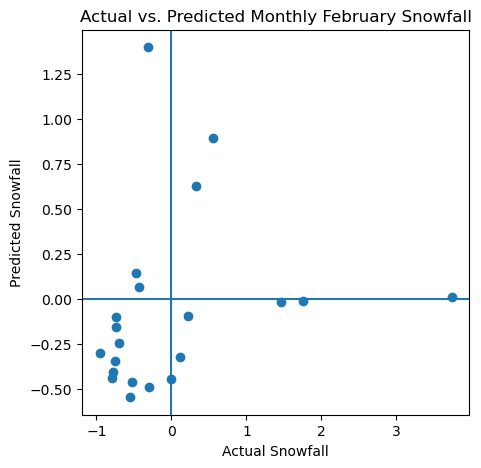

In [12]:
# Predict tornado count on test data
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # RMSE
corr = stats.pearsonr(y_test, y_pred) # Corr coeff
r2 = r2_score(y_test, y_pred) # Corr coeff

print(f'RMSE: {rmse}\nCorrelation Coeff: {corr.statistic}')
print(f'R-squared:', r2)
# Scatter plot of test vs. predicted data
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(y_test, y_pred)
ax.axvline(0)
ax.axhline(0)
ax.set_xlabel('Actual Snowfall')
ax.set_ylabel('Predicted Snowfall')
ax.set_title('Actual vs. Predicted Monthly February Snowfall')

In [13]:
# First look at accuracy score of model
print(f"RF train accuracy: {best_model.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {best_model.score(X_test, y_test):.3f}")

RF train accuracy: 0.633
RF test accuracy: -0.006


### It appears that this model does not have much skill when trying to predict the snowfall anomalies for the given month. However, if we take a look at the scatter plot, we see that the majority of points are less than zero for both predicted and actual values. Maybe rather than trying to predict the snowfall anomaly value, we could try having the model simply predict whether there will be above or below average snowfall for the given month. Let's try that approach...

In [10]:
# Add column to denote rows where snowfall is above avg
df_full["above_normal"] = (df_full["djf_snow_anom"] > 0).astype(int)
df_full

,ENSO,PDO,NAO,AO,PNA,IOD,djf_snow_anom,above_normal
Date,,,,,,,,
1951-01-01,-1.34,-1.19,0.08,-0.085,-0.41,-0.05,-0.688372,0
1952-01-01,0.08,-2.19,0.93,0.368,-1.98,0.05,-0.963804,0
1953-01-01,0.14,-0.16,0.33,-1.036,0.65,0.40,-0.928325,0
1954-01-01,0.38,-1.13,0.37,-0.148,-1.14,-0.29,-0.902203,0
1955-01-01,-0.98,-0.23,-1.84,-1.163,0.40,-0.42,-0.086900,0
...,...,...,...,...,...,...,...,...
2020-01-01,0.55,-1.41,1.34,2.419,-0.24,0.14,-0.957666,0
2021-01-01,-1.05,-0.61,-1.11,-2.484,0.19,0.12,1.466207,1
2022-01-01,-0.98,-2.40,1.08,0.848,1.01,-0.26,-0.735232,0


In [11]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay,
                             accuracy_score, precision_score, recall_score)

# Train/test split
split_date = "2006-01-01"
train = df_full[df_full.index < split_date]
test = df_full[df_full.index >= split_date]

X_train = train[['ENSO','PDO','NAO','AO','PNA','IOD']]
y_train = train['above_normal']

X_test = test[['ENSO','PDO','NAO','AO','PNA','IOD']]
y_test = test['above_normal']

# Time-series CV
tscv = TimeSeriesSplit(n_splits=5)


# Model CV grid
model_grids = {
    "RF": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [200, 500, 800],
            "max_depth": [3, 5, 7, None],
            "min_samples_split": [2, 4, 6]
        }
    },
}


# Get best model
best_models = {}
for name, cfg in model_grids.items():
    print(f"\nTuning {name}")
    
    gs = GridSearchCV(
        estimator=cfg["model"],
        param_grid=cfg["params"],
        cv=tscv,
        scoring="balanced_accuracy",
        n_jobs=-1
    )
    
    gs.fit(X_train, y_train)
    best_models[name] = gs.best_estimator_
    
    print("Best Params:", gs.best_params_)
    print("Best CV Balanced Accuracy:", gs.best_score_)


# Evaluate best model on test data
for name, model in best_models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:,1]

    print(f"\nDone {name}")




Tuning RF
Best Params: {'max_depth': 7, 'min_samples_split': 6, 'n_estimators': 500}
Best CV Balanced Accuracy: 0.5995238095238096

Done RF


# Model Performance using confusion matrix and ROC curve

Optimal Threshold: 0.3103674325674325
Accuracy:  0.737
Precision: 0.545
Recall:    1.000


<Figure size 640x480 with 0 Axes>

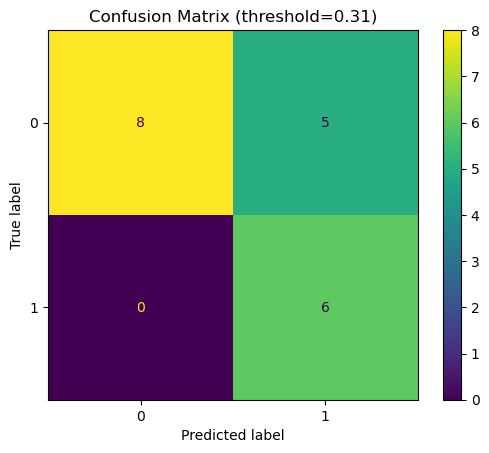

<Figure size 640x480 with 0 Axes>

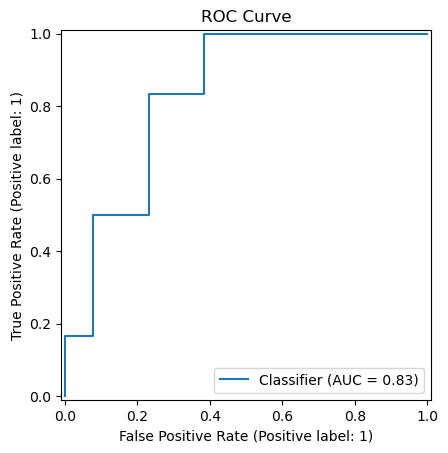

<Figure size 640x480 with 0 Axes>

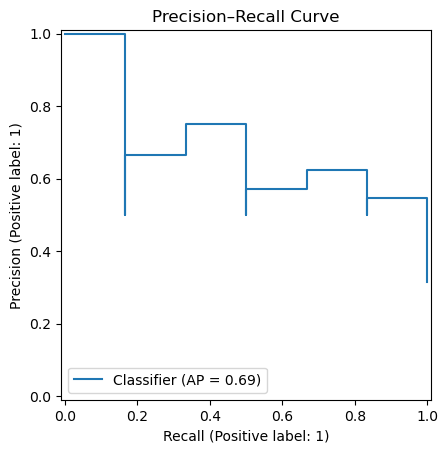

In [12]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Confusion matrix
cm = confusion_matrix(y_test, preds)

# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# Get optimal threshold for probs
j_scores = tpr - fpr
optimal_threshold = thresholds[j_scores.argmax()]

print("Optimal Threshold:", optimal_threshold)

# Performance evaluation
y_pred = (probs >= optimal_threshold).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)

print(f"Accuracy:  {acc:.3f}\nPrecision: {prec:.3f}\nRecall:    {rec:.3f}")

fig = plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f"Confusion Matrix (threshold={optimal_threshold:.2f})")
plt.show()


# ROC
fig = plt.figure()
RocCurveDisplay.from_predictions(y_test, probs)
plt.title("ROC Curve")
plt.show()

# PR
fig = plt.figure()
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.title("Precision–Recall Curve")
plt.show()


# Feature Importance

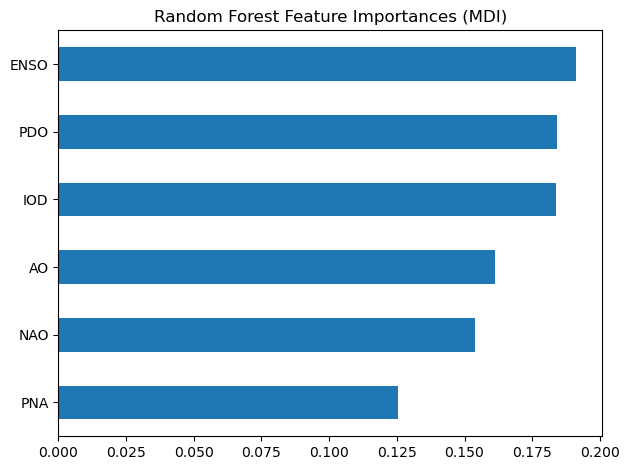

In [13]:
# Feature importance from Mean Decrease in Impurity (MDI)

# Grab feature names
feature_names = ['ENSO','PDO','NAO','AO','PNA','IOD']

# Create series of model feature importnances and sort
# from highest to lowest.
mdi_importances = pd.Series(
    model.feature_importances_, index=feature_names
).sort_values(ascending=True)

# Plot bar graph of MDI for each feature
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

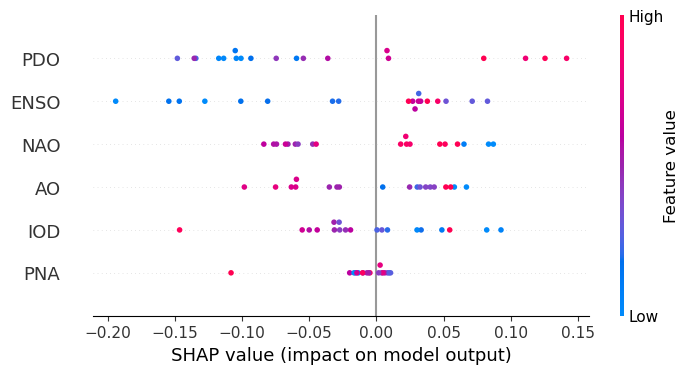

<Figure size 640x480 with 0 Axes>

In [16]:
# SHAP summary 
import shap

# SHAP explainer RF regression model
explainer = shap.TreeExplainer(model)
# Estimate SHAP values for test features based on rf model
shap_values = explainer(X_test)
# Select output = class 1
shap_values_class1 = shap_values[:, :, 1]

# Create summary plot (using beeswarm),
plt.figure(figsize=(12, 7))
shap.plots.beeswarm(shap_values_class1)
plt.tight_layout()

# Final Conclusions

When using the binary classifier method to predict whether the given month would have above or below average snowfall, we got a better idea of the relationships between monthly snowfall and teleconnections. I hesitate to say better performance overall since the previous method was predicting continuous values while this method was predicting binary values, which gives two different interpretations. However, seeing as we achieved ~73% accuracy on the test values and a 0.83 AUC in the ROC curve, I would say this isn't all that bad performance. 

Looking at feature importance, it's clear that the model tended to weigh the PDO and ENSO teleconnections the most heavily, favoring above average snowfall predictions with +PDO and +ENSO, and the opposite with -PDO and -ENSO. To me the most surprising thing is seeing the relative unimportance of the AO. Knowing that a -AO favors stronger and more frequent arctic air masses reaching down into CONUS, I would have expected it to be of more importance for the test city I chose, which is Baltimore, MD. 